In [1]:
import seaborn as sns
import os 
import numpy as np 
import pandas as pd 
from statsmodels.stats.anova import AnovaRM
import matplotlib.pyplot as plt
import pathlib as path
from scipy import stats

In [2]:
#define the relevant path to the current batch you wish to parse
project_name='birds'
experiment_name='experiment 1'
qualification_method='loose' #or 'loose' or #'none' (will take the entire sample of participants that we have values for)

add_similarity_values=False #this adds the similarity of each image pair in the actuall experiment it takes some time (15 minutes)

model_name='VGG' #the only model we work with atm so dont change
PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' 
PATH_TO_PROJECT=path.Path.cwd().parent.parent.parent / 'projects' / project_name 
PATH_TO_EXPERIMENT=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name
PATH_TO_OUTPUTS=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'figures and outputs' 
if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 c:\Users\User\Desktop\visual_memory_project\visual-memory-project\projects\birds\experiment 1\collected data


In [3]:
#PATH_TO_DATA = path.Path(r'C:\Users\User\Desktop\visualpilot')

all_directories_paths = [x[0] for x in os.walk(PATH_TO_BATCH) if 'batch' in x[0].split('\\')[-1] ]

#delete the following rows once batch 2 is actually filled with data and processed. 
time_gaps = set([x.split('\\')[-2] for x in all_directories_paths])
total_time_gaps = len(time_gaps)

In [4]:

if qualification_method=='none':
    filename = 'one_line_per_participant_all_info_all_subject_strict.csv' #note that why i do use the "strict" its irrelevant as all_subjects includes all of th em and not just qualified so criterion is irrelevant for this line
elif qualification_method in ['strict','loose']:
    filename = 'one_line_per_participant_all_info_valid_subjects_only_'+qualification_method+'.csv'
else: 
    raise Exception(f'the qualification method choosen {qualification_method} is invalid')

all_valid_subjects = pd.DataFrame([])
for batch in all_directories_paths:
    time_gap = path.Path(batch).parent.name
    PATH_PROCESED = batch/path.Path(filename)
    file = pd.read_csv(PATH_PROCESED,index_col=0)
    file['time_gap'] = time_gap
    file['worker_ID'] = file.index 
    file['batch_number'] = int(path.Path(batch).name.split(' ')[-1])
    
    all_valid_subjects = pd.concat([all_valid_subjects,file])


In [5]:
n_per_time_dic = {}
for time in time_gaps:
    n = all_valid_subjects['time_gap'].value_counts()[time]
    n_per_time_dic[time] = n 


my_order = list(n_per_time_dic.keys())
print(my_order)


['pilot_24_hours', 'pilot_one_week', 'pilot_two_week', 'pilot_same_day']


In [6]:
all_valid_subjects['time_gap'].value_counts()

pilot_one_week    32
pilot_same_day    21
pilot_24_hours    20
pilot_two_week    12
Name: time_gap, dtype: int64

In [7]:
## change manually the order from low to hight
my_order = [ 'pilot_same_day', 'pilot_24_hours','pilot_one_week','pilot_two_week']


palette_bar={'pilot_same_day':'firebrick','pilot_24_hours':'purple','pilot_one_week':'green','pilot_two_week':'gold'}
palette_strip={'pilot_same_day':'violet','pilot_24_hours':'pink','pilot_one_week':'blue','pilot_two_week':'goldenrod'}


lets check if there are duplicate subject names , if so we drop one of there rows 

In [8]:
print(f'there are {len(all_valid_subjects.index) - len(set(all_valid_subjects.index))}, duplicate subjects')

there are 0, duplicate subjects


In [9]:
#create long format dataframes for accuracy and rt seperately
rt_df = pd.melt(all_valid_subjects,id_vars=['worker_ID','time_gap'],value_vars=['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt'],var_name='layer')
accuracy_df = pd.melt(all_valid_subjects,id_vars=['worker_ID','time_gap'],value_vars=['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy'],var_name='layer')

In [10]:
all_valid_subjects.to_csv(PATH_TO_OUTPUTS / ('all_data_for_spss_analysis_'+qualification_method+' .csv'),index=False,)

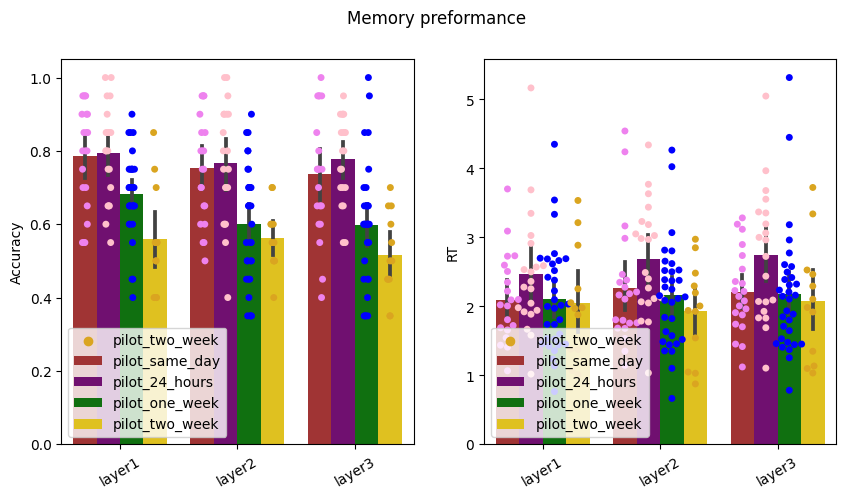

In [11]:


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data =accuracy_df, x='layer',y='value',hue='time_gap',ax=axes[0],palette=palette_bar,hue_order=my_order)
sns.stripplot(data =accuracy_df, x='layer',y='value',hue='time_gap',ax=axes[0],dodge=True,palette=palette_strip,jitter=True,hue_order=my_order)


axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_xlabel('')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[3:],labels[3:],loc='lower left')
axes[0].set_ylabel('Accuracy')


sns.barplot(data =rt_df, x='layer',y='value',hue='time_gap',ax=axes[1],palette=palette_bar,hue_order=my_order)
sns.swarmplot(data =rt_df, x='layer',y='value',hue='time_gap',ax=axes[1],palette=palette_strip,dodge=True,hue_order=my_order)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].legend(handles[3:],labels[3:],loc='lower left')
axes[1].set_ylabel('RT')
axes[1].set_xlabel('')

fig.suptitle('Memory preformance')
fig.savefig(PATH_TO_EXPERIMENT / ('all_batches_bar_graph_grouped_by_layer_'+qualification_method+'.svg'))


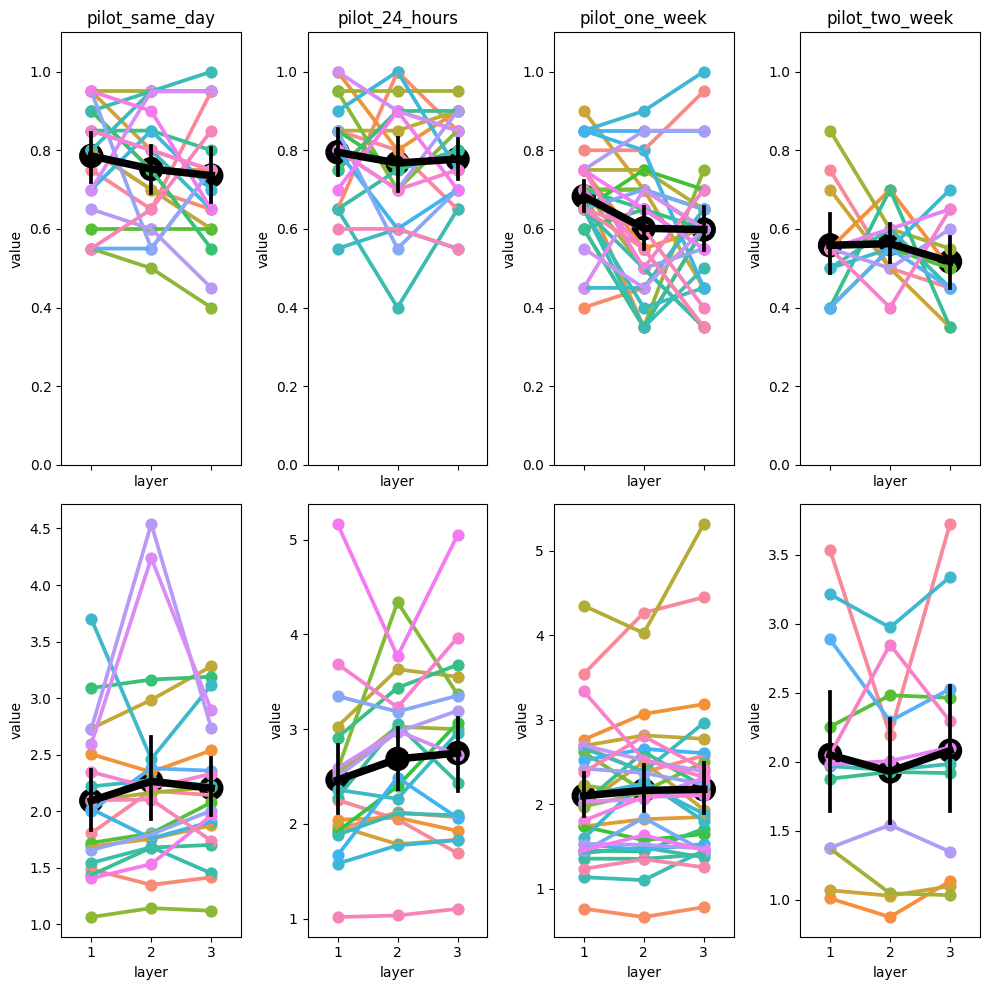

In [12]:
fig,axes=plt.subplots(nrows=2,ncols=total_time_gaps,figsize=(10,10),sharex=True,sharey=False)

for i,curtime in enumerate(my_order):
    #accuracy: 
    g=sns.pointplot(data=accuracy_df[accuracy_df['time_gap']==curtime],x='layer', y='value', hue='worker_ID', ax=axes[0,i])
    plt.setp(axes[0,i].lines, zorder=100)
    axes[0,i].set_ylim([0,1.1])
    sns.pointplot(data=accuracy_df[accuracy_df['time_gap']==curtime],x='layer', y='value',ax=axes[0,i],color='black',scale=2)
    plt.setp(axes[0,i].lines, zorder=200)
    axes[0,i].get_legend().remove() 
    axes[0,i].set_title(curtime)
    #rt: 
    g=sns.pointplot(data=rt_df[rt_df['time_gap']==curtime],x='layer', y='value', hue='worker_ID', ax=axes[1,i])
    plt.setp(axes[1,i].lines, zorder=100)
    sns.pointplot(data=rt_df[rt_df['time_gap']==curtime],x='layer', y='value',ax=axes[1,i],color='black',scale=2)
    plt.setp(axes[1,i].lines, zorder=200)
    plt.xticks([0,1,2],['1','2','3'])
    axes[1,i].get_legend().remove()

plt.tight_layout()
fig.savefig(PATH_TO_EXPERIMENT / ('line_graphs_per_condition_in_seperate_subplots_'+qualification_method+'.svg'))


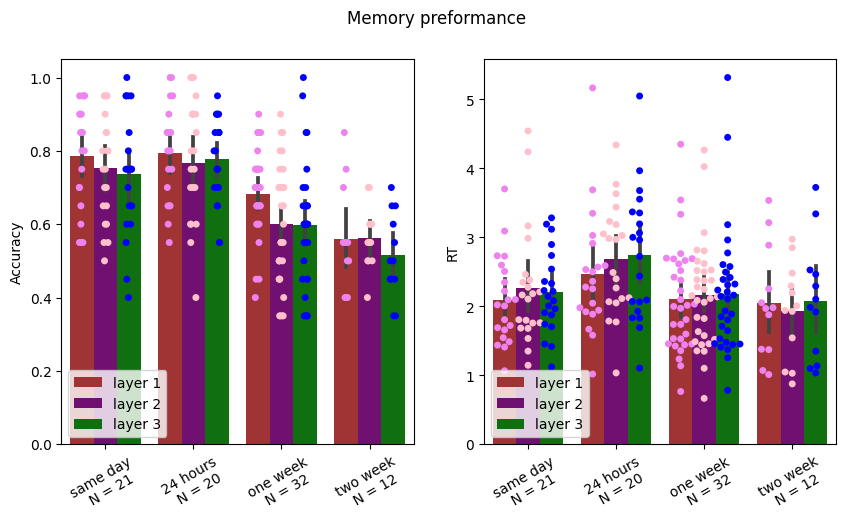

In [13]:
my_order = ['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
bar = sns.barplot(data =accuracy_df, x='time_gap',y='value',hue='layer',ax=axes[0],palette={'testing_layer_1_accuracy':'firebrick','testing_layer_2_accuracy':'purple','testing_layer_3_accuracy':'green'},hue_order=my_order,order=['pilot_same_day','pilot_24_hours','pilot_one_week','pilot_two_week'])
sns.stripplot(data =accuracy_df, x='time_gap',y='value',hue='layer',ax=axes[0],dodge=True,palette={'testing_layer_1_accuracy':'violet','testing_layer_2_accuracy':'pink','testing_layer_3_accuracy':'blue'},hue_order=my_order,order=['pilot_same_day','pilot_24_hours','pilot_one_week','pilot_two_week'])
# axes[0].set_xticklabels(labels=['pilot_same_day','pilot_24_hours','pilot_one_week'],rotation=30)
axes[0].set_xlabel('')
labels_times = [f'same day\n N = {n_per_time_dic["pilot_same_day"]}',
          f'24 hours\n N = {n_per_time_dic["pilot_24_hours"]}',
          f'one week\n N = {n_per_time_dic["pilot_one_week"]}',
          f'two week\n N = {n_per_time_dic["pilot_two_week"]}']

axes[0].set_xticklabels(labels=labels_times,rotation=30)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[3:],['layer 1','layer 2','layer 3'],loc='lower left')
axes[0].set_ylabel('Accuracy')



my_order = ['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']

sns.barplot(data =rt_df, x='time_gap',y='value',hue='layer',ax=axes[1],palette={'testing_layer_1_rt':'firebrick','testing_layer_2_rt':'purple','testing_layer_3_rt':'green'},hue_order=my_order,order=['pilot_same_day','pilot_24_hours','pilot_one_week','pilot_two_week'])
sns.swarmplot(data =rt_df,x='time_gap',y='value',hue='layer',ax=axes[1],palette={'testing_layer_1_rt':'violet','testing_layer_2_rt':'pink','testing_layer_3_rt':'blue'},dodge=True,hue_order=my_order,order=['pilot_same_day','pilot_24_hours','pilot_one_week','pilot_two_week'])

axes[1].set_xticklabels(labels=labels_times,rotation=30)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[3:],['layer 1','layer 2','layer 3'],loc='lower left')
axes[1].set_ylabel('RT')
axes[1].set_xlabel('')


fig.suptitle('Memory preformance')
fig.savefig(PATH_TO_EXPERIMENT / ('all_batches_bar_graph_grouped_by_timegap_'+qualification_method+'.svg'))


In [14]:
# lets look at the std 
for layer in np.unique(accuracy_df['layer'].values):
    curr_df = accuracy_df[accuracy_df['layer'] == layer]
    curr_vals = curr_df['value']
    layer_num = layer.split('_')[-2]
    print(f'the std for layer {layer_num} is {curr_vals.values.std()}')

    for time in np.unique(curr_df['time_gap'].values):

        curr_vals_time = curr_df[curr_df['time_gap'] == time]['value'] 
        print(f'the std for layer {layer_num} and time gap: {time} is {curr_vals_time.values.std()}')



the std for layer 1 is 0.15020631716496805
the std for layer 1 and time gap: pilot_24_hours is 0.12835497652993436
the std for layer 1 and time gap: pilot_one_week is 0.11292238415721657
the std for layer 1 and time gap: pilot_same_day is 0.13727176481332926
the std for layer 1 and time gap: pilot_two_week is 0.13667682889047272
the std for layer 2 is 0.1693423060224365
the std for layer 2 and time gap: pilot_24_hours is 0.1583311403356901
the std for layer 2 and time gap: pilot_one_week is 0.1593366988290833
the std for layer 2 and time gap: pilot_same_day is 0.1418216439222422
the std for layer 2 and time gap: pilot_two_week is 0.08196798155377498
the std for layer 3 is 0.17407789689346323
the std for layer 3 and time gap: pilot_24_hours is 0.11562331079847175
the std for layer 3 and time gap: pilot_one_week is 0.16176969306316308
the std for layer 3 and time gap: pilot_same_day is 0.16340342796927132
the std for layer 3 and time gap: pilot_two_week is 0.11055415967851334


## this section creates a long dataformat for all participants from the 3 possible time gaps
### cells running additional analyses on this long format: 
* checks how position in the encoding stream effects performence 
* creates a multi level logistic regression that examine the contribution of the similarity levels between each pair across the 3 defined levels



In [15]:
#read data from all time gaps: 

all_participants_results_files=list(set([sub_path.parent.parent for sub_path in list(PATH_TO_EXPERIMENT.rglob('*.csv')) if '-' in sub_path.name]))
#remove the sameday batches that are not 6 or 7
all_participants_batch_locations= all_participants_results_files
all_participants_batch_locations

[WindowsPath('c:/Users/User/Desktop/visual_memory_project/visual-memory-project/projects/birds/experiment 1/collected data/pilot_same_day/batch 1'),
 WindowsPath('c:/Users/User/Desktop/visual_memory_project/visual-memory-project/projects/birds/experiment 1/collected data/pilot_24_hours/batch 1'),
 WindowsPath('c:/Users/User/Desktop/visual_memory_project/visual-memory-project/projects/birds/experiment 1/collected data/pilot_one_week/batch 1'),
 WindowsPath('c:/Users/User/Desktop/visual_memory_project/visual-memory-project/projects/birds/experiment 1/collected data/pilot_two_week/batch 1'),
 WindowsPath('c:/Users/User/Desktop/visual_memory_project/visual-memory-project/projects/birds/experiment 1/collected data/pilot_one_week/batch 2')]

In [16]:
#create a long format encoding and test dataframes: 
all_subjects_encoding_long_format_df=pd.DataFrame()
all_subjects_test_long_format_df=pd.DataFrame()
for cur_batch in all_participants_batch_locations:
    cur_sub_encoding_df=pd.read_csv(cur_batch / 'all_subjects_encoding_df.csv')
    cur_sub_test_df=pd.read_csv(cur_batch / 'all_subjects_test_df.csv')

    cur_sub_encoding_df['time_gap']=cur_batch.parent.name
    cur_sub_test_df['time_gap']=cur_batch.parent.name

    all_subjects_encoding_long_format_df=pd.concat([all_subjects_encoding_long_format_df,cur_sub_encoding_df],axis=0)
    all_subjects_test_long_format_df=pd.concat([all_subjects_test_long_format_df,cur_sub_test_df],axis=0)


all_valid_test_df_long_format=pd.DataFrame()
all_valid_encoding_df_long_format=pd.DataFrame()

for cur_sub in all_valid_subjects.index:
    #some subject names are the full length name to thier csv: if this is the case, change it to take only the amazong worker id: 
    cur_sub_encoding=all_subjects_encoding_long_format_df[all_subjects_encoding_long_format_df['subject']==cur_sub]
    cur_sub_test=all_subjects_test_long_format_df[all_subjects_test_long_format_df['subject']==cur_sub]
    all_valid_encoding_df_long_format=pd.concat([all_valid_encoding_df_long_format,cur_sub_encoding],axis=0)
    all_valid_test_df_long_format=pd.concat([all_valid_test_df_long_format,cur_sub_test],axis=0)

print('only valid participants counts:')
print(all_valid_test_df_long_format['time_gap'].value_counts())
print('all participants counts:')
print(all_subjects_test_long_format_df['time_gap'].value_counts())


only valid participants counts:
pilot_one_week    1980
pilot_same_day    1260
pilot_24_hours    1200
pilot_two_week     720
Name: time_gap, dtype: int64
all participants counts:
pilot_one_week    2700
pilot_same_day    1620
pilot_24_hours    1560
pilot_two_week     840
Name: time_gap, dtype: int64


In [17]:
#create a dataframe which allows the analysis of encoding position: 

images_position_accuracy_df=pd.DataFrame(columns=['img_name','target_layer','distractor_layer','serial_position_in_encoding','is_correct','viewed_by_encoding','viewed_by_test','distractor_side','time_gap'])
target_images=set(all_valid_encoding_df_long_format['target_image'].unique())-{'left.jpg','right.jpg'}
for cur_img in target_images:
     
    img_df=pd.DataFrame(columns=['img_name','target_layer','distractor_layer','serial_position_in_encoding','is_correct','viewed_by_encoding','viewed_by_test','distractor_side','time_gap'])
    cur_encoding_img_info=all_valid_encoding_df_long_format[all_valid_encoding_df_long_format['target_image']==cur_img]
    img_df['target_layer']=cur_encoding_img_info['layer'].values
    img_df['serial_position_in_encoding']=cur_encoding_img_info['trials.thisTrialN'].values
    img_df['viewed_by_encoding']= cur_encoding_img_info['subject'].values
    img_df['img_name']=cur_img
    img_df['time_gap']=cur_encoding_img_info['time_gap'].values
    #get from test: 
    cur_test_img_info=all_valid_test_df_long_format[(all_valid_test_df_long_format['image1']==cur_img) | (all_valid_test_df_long_format['image2']==cur_img)]

    img_df['distractor_layer']=cur_test_img_info['layer'].values
    img_df['is_correct']=cur_test_img_info['test_test_response.corr'].values
    img_df['distractor_side']=cur_test_img_info['correct'].values
    img_df['viewed_by_test']=cur_test_img_info['subject'].values

    images_position_accuracy_df=pd.concat([images_position_accuracy_df,img_df],axis=0)
#remember to change left to right and right to left: 


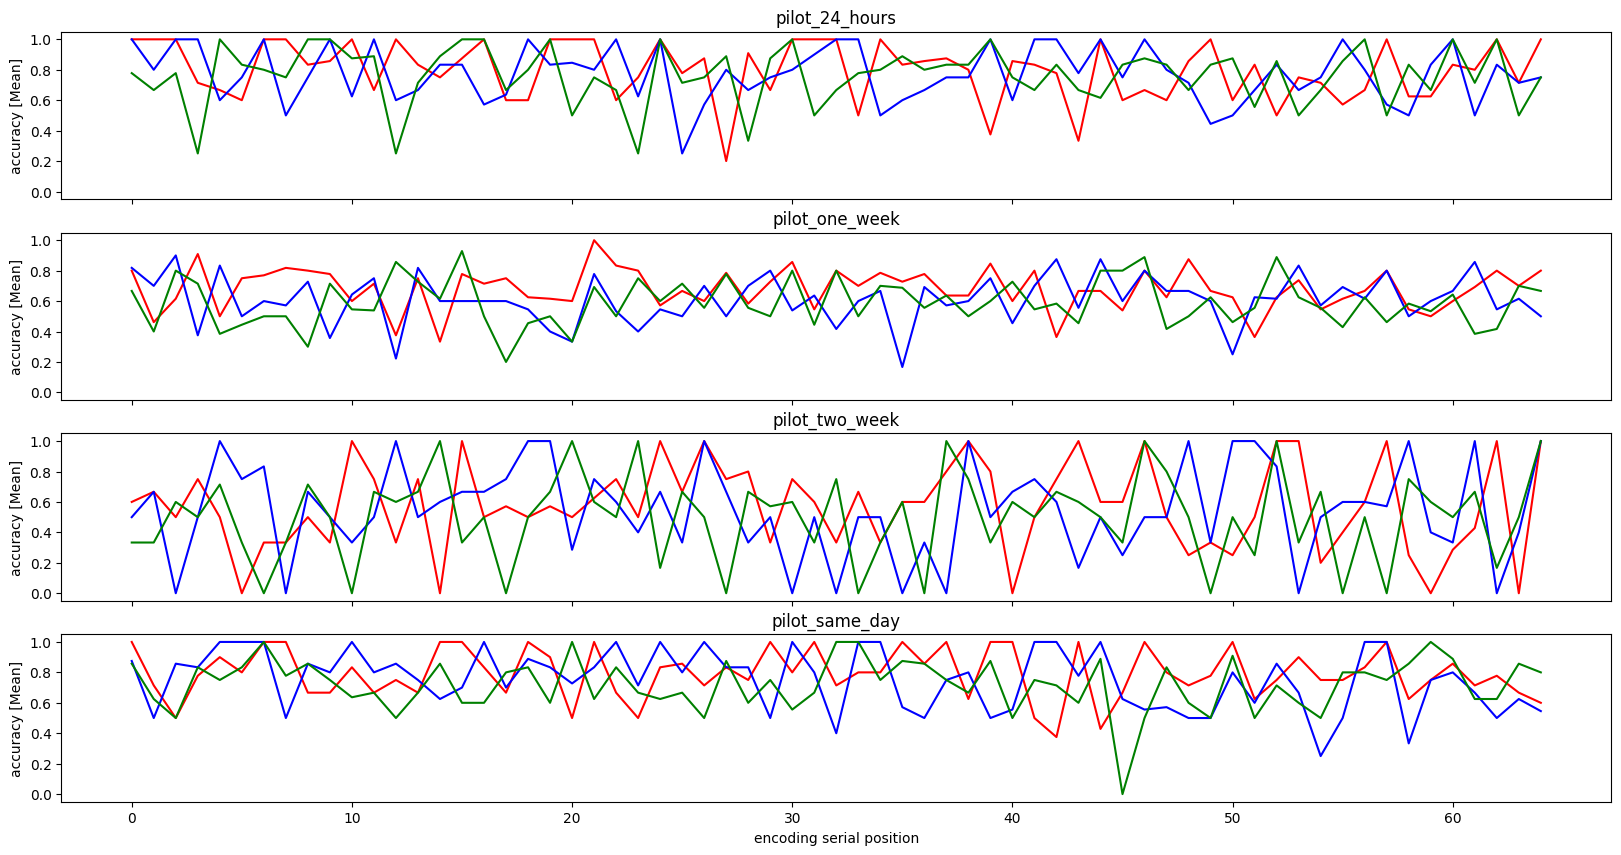

In [18]:
#create a plot for each time gap, X is target image serial position in encoding, y is the average accuracy (this analysis probably needs alot of data)
grouped_df=images_position_accuracy_df.groupby(['time_gap','distractor_layer','serial_position_in_encoding']).aggregate({'is_correct':['mean','std']})
fig,axes=plt.subplots(nrows=total_time_gaps,ncols=1,figsize=(20,10),sharex=True,sharey=True)
for i,cur_timegap in enumerate(time_gaps):
    grouped_df.loc[cur_timegap, 1.0]['is_correct', 'mean'].plot(ax=axes[i],color='r')
    grouped_df.loc[cur_timegap, 2.0]['is_correct', 'mean'].plot(ax=axes[i],color='b')
    grouped_df.loc[cur_timegap, 3.0]['is_correct', 'mean'].plot(ax=axes[i],color='g')
    axes[i].set_title(cur_timegap)
    axes[i].set_xlabel('encoding serial position')
    axes[i].set_ylabel('accuracy [Mean]')



In [19]:
#here we do some statistics: mixed effects (1 between (time gap - 3 levels) and 1 within factors (layer representation - 3 levels)) and some assumption checks
import pingouin as pg

#check for sphercity assumption" 
print('\n---sphericity assumption----------')
print(pg.sphericity(data=accuracy_df, dv='value', subject='worker_ID', within='layer')[-1])

#homoscedasticity
print('\n---homoscedasticity assumption---')
for layer_val in accuracy_df['layer'].unique():
    print(f'layer: {layer_val}:')
    print(pg.homoscedasticity(accuracy_df[accuracy_df['layer']==layer_val], dv='value', group='time_gap'))

#mixed anova:""
print('\n-----anova results--------------')
print(pg.mixed_anova(dv='value', between='time_gap', within='layer', subject='worker_ID', data=accuracy_df))

#assumption of normality: 
print('\n-----normality assumption-------')
accuracy_df['factor_comb']=accuracy_df["layer"] + '_'+accuracy_df["time_gap"]
print(pg.normality(accuracy_df, dv='value', group='factor_comb'))


print('\n---------anova results----------')
print(pg.mixed_anova(dv='value', between='time_gap', within='layer', subject='worker_ID', data=accuracy_df))




---sphericity assumption----------
0.503155932469384

---homoscedasticity assumption---
layer: testing_layer_1_accuracy:
               W      pval  equal_var
levene  0.700964  0.554186       True
layer: testing_layer_2_accuracy:
               W      pval  equal_var
levene  2.853088  0.042318      False
layer: testing_layer_3_accuracy:
               W      pval  equal_var
levene  0.566578  0.638612       True

-----anova results--------------
        Source        SS  DF1  DF2        MS          F         p-unc  \
0     time_gap  1.889921    3   81  0.629974  17.386443  8.339822e-09   
1        layer  0.142118    2  162  0.071059   5.611312  4.402936e-03   
2  Interaction  0.054730    6  162  0.009122   0.720306  6.337912e-01   

        np2       eps  
0  0.391706       NaN  
1  0.064787  0.983851  
2  0.025985       NaN  

-----normality assumption-------
                                                W      pval  normal
factor_comb                                                

In [20]:
#mixed anova:""
print('\n-----anova results--------------')
accuracy_df
print(pg.mixed_anova(dv='value', between='time_gap', within='layer', subject='worker_ID', data=accuracy_df))


-----anova results--------------
        Source        SS  DF1  DF2        MS          F         p-unc  \
0     time_gap  1.889921    3   81  0.629974  17.386443  8.339822e-09   
1        layer  0.142118    2  162  0.071059   5.611312  4.402936e-03   
2  Interaction  0.054730    6  162  0.009122   0.720306  6.337912e-01   

        np2       eps  
0  0.391706       NaN  
1  0.064787  0.983851  
2  0.025985       NaN  


In [21]:
#this section adds the similarity value of each traget-distrator pair across the 3 levels of similarity: 

similarity_df = pd.read_csv(PATH_TO_PROJECT/f'similarity_{project_name}_all_{model_name}.csv')
similarity_df['image1']=similarity_df['image1'].str.replace('.pkl','.jpg',regex=True)
similarity_df['image2']=similarity_df['image2'].str.replace('.pkl','.jpg',regex=True)
similarity_df.head(10)

,Unnamed: 0,image1,image2,level_0,level_1,level_2,level_3,level_4,level_5,level_6,model,category1,category2
0,0,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BABBLER_2.jpg,0.385141,0.331468,0.242854,0.195526,0.366272,0.517392,0.600775,VGG,NaN,NaN
1,1,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BABBLER_3.jpg,0.452410,0.357329,0.262565,0.214199,0.377011,0.470686,0.502683,VGG,NaN,NaN
2,2,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BABBLER_4.jpg,0.423177,0.334778,0.230815,0.224113,0.465089,0.529393,0.598977,VGG,NaN,NaN
3,3,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BABBLER_5.jpg,0.404764,0.331832,0.247395,0.180204,0.344248,0.475055,0.581427,VGG,NaN,NaN
4,4,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BOOBY_1.jpg,0.386937,0.330560,0.219192,0.164568,0.106307,0.148920,0.197289,VGG,NaN,NaN
5,5,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BOOBY_2.jpg,0.329284,0.306200,0.235460,0.164741,0.177369,0.176885,0.201086,VGG,NaN,NaN
6,6,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BOOBY_3.jpg,0.271409,0.216480,0.148011,0.097351,0.076787,0.157740,0.201573,VGG,NaN,NaN
7,7,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BOOBY_4.jpg,0.367749,0.323739,0.227172,0.162911,0.123062,0.186875,0.243961,VGG,NaN,NaN
8,8,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BOOBY_5.jpg,0.372173,0.316164,0.232810,0.152963,0.077227,0.161134,0.186913,VGG,NaN,NaN
9,9,ABBOTTS_BABBLER_1.jpg,ABYSSINIAN_GROUND_HORNBILL_1.jpg,0.376973,0.314195,0.211522,0.142752,0.137062,0.210027,0.280994,VGG,NaN,NaN


In [22]:
similarity_df['arithmentic_mean'] = similarity_df[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].mean(axis=1)

In [24]:
from scipy.stats import hmean

#similarity_df['harmonic_mean']
similarity_df[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].apply(hmean, axis=1)

KeyboardInterrupt: 

In [25]:
hm = np.apply_along_axis(lambda row: np.reciprocal(np.mean(np.reciprocal(row[row > 0]))), axis=1, arr=similarity_df[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].values)

In [27]:
similarity_df['harmonic_mean'] = hm

In [28]:
similarity_df

,Unnamed: 0,image1,image2,level_0,level_1,level_2,level_3,level_4,level_5,level_6,model,category1,category2,arithmentic_mean,harmonic_mean
0,0,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BABBLER_2.jpg,0.385141,0.331468,0.242854,0.195526,0.366272,0.517392,0.600775,VGG,NaN,NaN,0.377061,0.330611
1,1,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BABBLER_3.jpg,0.452410,0.357329,0.262565,0.214199,0.377011,0.470686,0.502683,VGG,NaN,NaN,0.376698,0.345638
2,2,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BABBLER_4.jpg,0.423177,0.334778,0.230815,0.224113,0.465089,0.529393,0.598977,VGG,NaN,NaN,0.400906,0.352587
3,3,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BABBLER_5.jpg,0.404764,0.331832,0.247395,0.180204,0.344248,0.475055,0.581427,VGG,NaN,NaN,0.366418,0.321022
4,4,ABBOTTS_BABBLER_1.jpg,ABBOTTS_BOOBY_1.jpg,0.386937,0.330560,0.219192,0.164568,0.106307,0.148920,0.197289,VGG,NaN,NaN,0.221968,0.186972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530120,49995,AZURE_TIT_5.jpg,GYRFALCON_1.jpg,0.367362,0.304895,0.220343,0.207478,0.261943,0.244901,0.279024,VGG,NaN,NaN,0.269421,0.260757
2530121,49996,AZURE_TIT_5.jpg,GYRFALCON_2.jpg,0.354621,0.312375,0.230282,0.148270,0.189167,0.260370,0.292457,VGG,NaN,NaN,0.255363,0.236052
2530122,49997,AZURE_TIT_5.jpg,GYRFALCON_3.jpg,0.313202,0.266745,0.181295,0.109697,0.117937,0.182625,0.254921,VGG,NaN,NaN,0.203774,0.177434
2530123,49998,AZURE_TIT_5.jpg,GYRFALCON_4.jpg,0.392295,0.336401,0.265389,0.251190,0.289514,0.278265,0.284255,VGG,NaN,NaN,0.299615,0.293666


In [29]:
all_valid_test_df_long_format['time_gap'].value_counts()

pilot_one_week    1980
pilot_same_day    1260
pilot_24_hours    1200
pilot_two_week     720
Name: time_gap, dtype: int64

In [30]:
#add the similarity columns to the long data format:
 
if (PATH_TO_EXPERIMENT / 'long_format_test_with_similarity.csv').exists():
    print('loading a pre existing long dataframe with similarity values\nlocated at:',PATH_TO_EXPERIMENT / 'long_format_test_with_similarity.csv')
    all_valid_test_df_long_format=pd.read_csv(PATH_TO_EXPERIMENT / 'long_format_test_with_similarity.csv')
else: 
    print('calculating a long dataframe with similarity values')
    sim_levels_colnames=[colname for colname in similarity_df.columns if 'level_' in colname]

    #get all unique pairs: 
    all_pairs=[set([img1,img2]) for img1,img2 in all_valid_test_df_long_format[['image1','image2']].values]
    all_unique_pairs=[]
    for pair in all_pairs:
        if pair not in all_unique_pairs:
            all_unique_pairs.append(pair)

    print(f'running on {len(all_unique_pairs)} options of the displayed image pairs: extracting thier similarity level across all layers')

    missing_similarity_pairs=[]
    for img1,img2 in all_unique_pairs:
        #get all the instances from the long format data that contains this pair: 
        sim_vals=similarity_df.loc[((similarity_df['image1']==img1) & (similarity_df['image2']==img2)) 
            | ((similarity_df['image1']==img2) & (similarity_df['image2']==img1)),sim_levels_colnames]

        if len(sim_vals)==0: #if the images are not in the similarity df (could happen if using a newer version of the similary df where some images were filtered out)
            missing_similarity_pairs.append((img1,img2))
        else: 
            all_valid_test_df_long_format.loc[((all_valid_test_df_long_format['image1']==img1) & (all_valid_test_df_long_format['image2']==img2)) 
                | ((all_valid_test_df_long_format['image1']==img2) & (all_valid_test_df_long_format['image2']==img1)),sim_levels_colnames]=sim_vals.values[0,:].tolist()

    print('the following pairs were missing from the large similarity df:\n',missing_similarity_pairs)
    #save
    all_valid_test_df_long_format.to_csv(PATH_TO_EXPERIMENT / 'long_format_test_with_similarity.csv',index=False)   

loading a pre existing long dataframe with similarity values
located at: c:\Users\User\Desktop\visual_memory_project\visual-memory-project\projects\birds\experiment 1\long_format_test_with_similarity.csv


In [32]:
all_valid_test_df_long_format
all_valid_test_df_long_format['harmonic_mean'] = np.apply_along_axis(lambda row: np.reciprocal(np.mean(np.reciprocal(row[row > 0]))), axis=1, arr=all_valid_test_df_long_format[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].values)
all_valid_test_df_long_format['arithmetic_mean'] = all_valid_test_df_long_format[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].mean(axis=1)

In [34]:
all_valid_test_df_long_format[['test_test_response.corr','harmonic_mean','arithmetic_mean']]

,test_test_response.corr,harmonic_mean,arithmetic_mean
0,1.0,0.170043,0.216330
1,1.0,0.251986,0.297034
2,1.0,0.155817,0.190311
3,1.0,0.151954,0.185062
4,0.0,0.220473,0.269322
...,...,...,...
5155,1.0,0.214025,0.220455
5156,1.0,0.226031,0.283549
5157,0.0,0.239729,0.273686
5158,1.0,0.231660,0.272694


In [348]:
rel_df = all_valid_test_df_long_format[['layer','test_test_response.corr','image1','image2','time_gap','level_0','level_3','level_6']]

total_accuracy = pd.DataFrame([])
for time in rel_df['time_gap'].unique():

  cur_df = rel_df[rel_df['time_gap'] == time]

  # First, combine the two image columns into one
  cur_df['combined_images'] = cur_df.apply(lambda x: f'{min(x["image1"], x["image2"])}_{max(x["image1"], x["image2"])}', axis=1)

  # Create a dictionary to store the results
  result = {}
  similarity = []
  # Iterate through the unique combinations of image names
  for image_combination in cur_df['combined_images'].unique():
    accuracy = cur_df[cur_df['combined_images'] == image_combination]['test_test_response.corr'].mean()
    layer = cur_df[cur_df['combined_images'] == image_combination]['layer'].iloc[0]
    N = len(cur_df[cur_df['combined_images'] == image_combination])
    sim = cur_df[cur_df['combined_images'] == image_combination][['level_0','level_3','level_6']].iloc[0]
    if layer == 1.0:
      sim = sim[0]
    elif layer == 2.0:
      sim = sim[1]
    else:
      sim = sim[2]
    result[image_combination] = [accuracy,layer,time,N]

    similarity.append(sim)

  # Convert the dictionary to a dataframe
  similarity = pd.Series(similarity,name='similarity')
  result_df = pd.DataFrame.from_dict(result, orient='index', columns=['accuracy','layer','time_gap','N'])

  similarity = similarity.reset_index().set_index(result_df.index)
  result_df = pd.concat([result_df,similarity],axis = 1)
  total_accuracy = pd.concat([total_accuracy,result_df])



total_accuracy = total_accuracy.drop('index',axis =1 )

C:\Users\User\AppData\Local\Temp\ipykernel_24172\793102212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['combined_images'] = cur_df.apply(lambda x: f'{min(x["image1"], x["image2"])}_{max(x["image1"], x["image2"])}', axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_24172\793102212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['combined_images'] = cur_df.apply(lambda x: f'{min(x["image1"], x["image2"])}_{max(x["image1"], x["image2"])}', axis=1)
C:\Users\User\AppData\Local\Temp\ipy

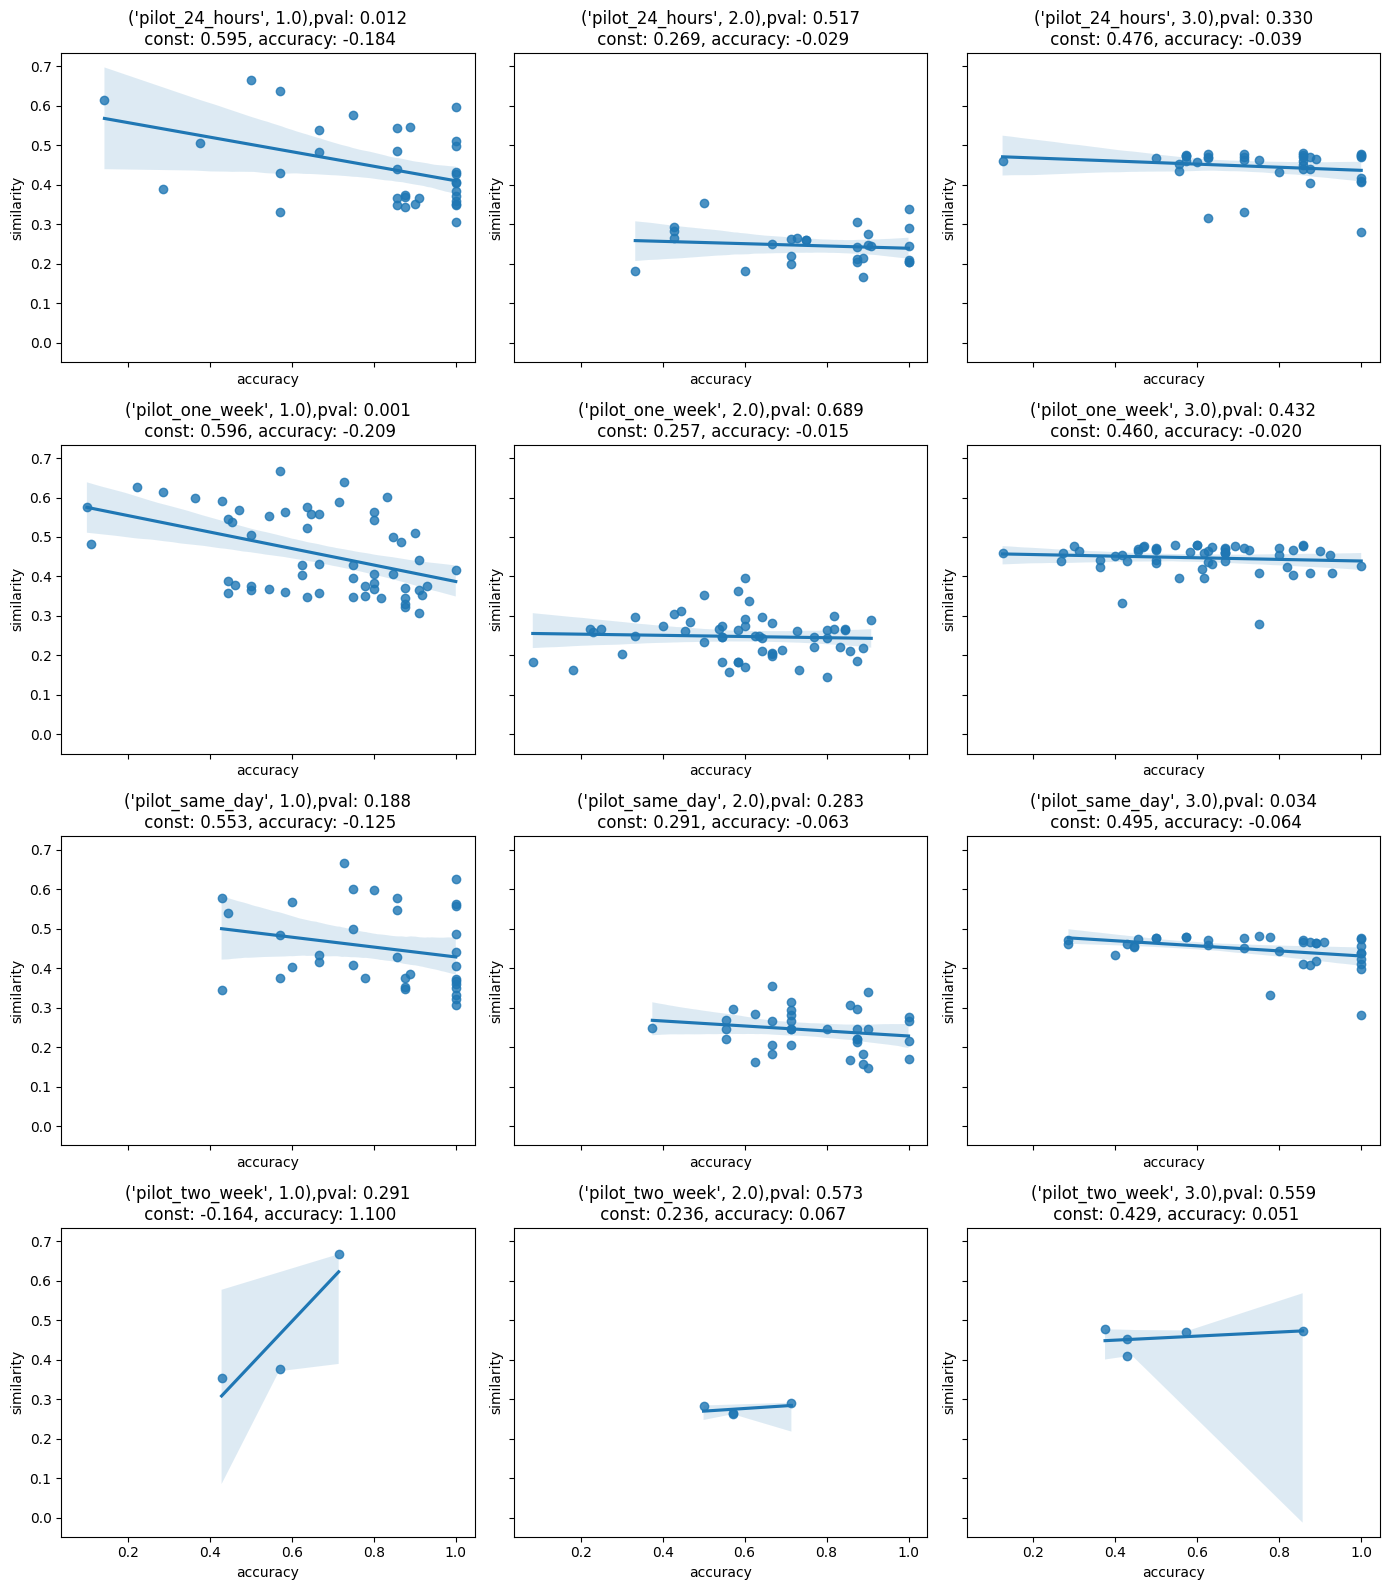

In [360]:
import statsmodels.api as sm

temp=total_accuracy.groupby(['time_gap','layer'])
temp.groups.keys()
list(temp.groups.keys())[0]

first_df=temp.groups[('pilot_24_hours', 1.0)]
first_df


fig,axs = plt.subplots(4,3,figsize = (14,16),sharex=True,sharey=True)
axs = axs.ravel()
for idx , (group_name,df) in enumerate(temp):
    cur_df = pd.DataFrame(df)
    cur_df = cur_df[cur_df['N'] > 4 ]
    x = cur_df['accuracy']
    y = cur_df['similarity']
    # fit a linear regression model to the data
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    const,acc = model.params
    # obtain the p-value for the regression model
    p_value = model.pvalues[1]

    sns.regplot(data = cur_df[['accuracy','similarity']],x='accuracy',y='similarity',ax=axs[idx])
    axs[idx].set_title(f'{group_name},pval: {p_value:.3f}\n const: {const:.3f}, accuracy: {acc:.3f}')
    
plt.tight_layout()

In [294]:
all_valid_test_df_long_format.rename(columns={'test_test_response.corr':'is_correct','test_test_response.rt':'rt','trials_2.thisTrialN':'trial_num'},inplace=True)
all_subjects_test_long_format_df.rename(columns={'test_test_response.corr':'is_correct','test_test_response.rt':'rt','trials_2.thisTrialN':'trial_num'},inplace=True)
#create grouped sim values: 
all_valid_test_df_long_format['sim_layer_1']=all_valid_test_df_long_format['level_0']
all_valid_test_df_long_format['sim_layer_2']=all_valid_test_df_long_format['level_3']
all_valid_test_df_long_format['sim_layer_3']=all_valid_test_df_long_format['level_6']


In [295]:
all_valid_test_df_long_format['time_gap_numeric']=all_valid_test_df_long_format['time_gap'].map({'pilot_same_day':'0','pilot_24_hours':'1','pilot_one_week':'2','pilot_two_week':'3'})
all_valid_test_df_long_format.dropna(inplace=True)
print('valid long format count: ')
print(all_valid_test_df_long_format['time_gap_numeric'].value_counts())

all_subjects_test_long_format_df['time_gap_numeric']=all_subjects_test_long_format_df['time_gap'].map({'pilot_same_day':'0','pilot_24_hours':'1','pilot_one_week':'2','pilot_two_week':'3'})
all_subjects_test_long_format_df.dropna(inplace=True)
print('all long format')
print(all_subjects_test_long_format_df['time_gap_numeric'].value_counts())



valid long format count: 
0    1080
2     840
1     720
Name: time_gap_numeric, dtype: int64
all long format
2    2700
0    1620
1    1560
Name: time_gap_numeric, dtype: int64


In [296]:
#test: multiply the sample by 3: 
tempdf1=all_valid_test_df_long_format.copy()

tempdf2=all_valid_test_df_long_format.copy()
tempdf2['subject']=[str(ind)+'_2' for ind in all_valid_test_df_long_format['subject']]
tempdf2.reset_index(inplace=True)
tempdf3=all_valid_test_df_long_format.copy()
tempdf3['subject']=[str(ind)+'_3' for ind in all_valid_test_df_long_format['subject']]
tempdf3.reset_index(inplace=True)

fake_3_times_original=pd.concat([tempdf1,tempdf2,tempdf3],axis=0)
fake_3_times_original.head(5)

#test the full design in anova (but with the faked x3 data sample)
print('full design')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=fake_3_times_original)


full design


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,1.212230,2,129,0.606115,31.518561,7.156352e-12,0.328255,NaN
1,layer,0.212159,2,258,0.106080,8.995347,1.673244e-04,0.065186,0.974619
2,Interaction,0.050321,4,258,0.012580,1.066783,3.734084e-01,0.016270,NaN


In [297]:
print('full design')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format[~(all_valid_test_df_long_format['subject']=='A1P2XKONWAOXHP')])

full design


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.328937,2,40,0.164469,8.412378,0.000892,0.296081,NaN
1,layer,0.075155,2,80,0.037578,3.292296,0.042264,0.076048,0.956917
2,Interaction,0.031743,4,80,0.007936,0.695281,0.597414,0.033596,NaN


In [298]:
print('design - no mid level representation')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format[~(all_valid_test_df_long_format['layer']==2.0)]
)

design - no mid level representation


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.276295,2,41,0.138148,11.555658,0.000105,0.360487,NaN
1,layer,0.062756,1,41,0.062756,4.457871,0.040881,0.098066,1.0
2,Interaction,0.016317,2,41,0.008158,0.579532,0.564682,0.027493,NaN


In [299]:
print('design - no 24h representation')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format[~(all_valid_test_df_long_format['time_gap']=='pilot_24_hours')]
)

design - no 24h representation


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.275913,1,30,0.275913,13.219628,0.001027,0.305871,NaN
1,layer,0.066719,2,60,0.033359,2.565627,0.085281,0.078783,0.901453
2,Interaction,0.011469,2,60,0.005735,0.441036,0.645438,0.014488,NaN


In [300]:
print('design -no layer 2, no 24h representation')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format[~(all_valid_test_df_long_format['layer']==2.0) & ~(all_valid_test_df_long_format['time_gap']=='pilot_24_hours')]
)

design -no layer 2, no 24h representation


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.183492,1,30,0.183492,14.620573,0.000618,0.327664,NaN
1,layer,0.062500,1,30,0.062500,3.780000,0.061299,0.111901,1.0
2,Interaction,0.011468,1,30,0.011468,0.693600,0.411524,0.022598,NaN


In [301]:
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format
)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.404077,2,41,0.202038,10.017527,0.000287,0.328255,NaN
1,layer,0.070720,2,82,0.035360,2.858986,0.063057,0.065186,0.974619
2,Interaction,0.016774,4,82,0.004193,0.339055,0.850874,0.016270,NaN


In [302]:
all_valid_test_df_long_format

,Unnamed: 0,layer,correct,test_test_response.keys,is_correct,rt,trials_2.thisRepN,trial_num,trials_2.thisN,trials_2.thisIndex,...,level_1,level_2,level_3,level_4,level_5,level_6,sim_layer_1,sim_layer_2,sim_layer_3,time_gap_numeric
0,0,1.0,left,left,1.0,6.1472,0.0,0.0,0.0,0.0,...,0.343748,0.204189,0.119700,0.101498,0.146254,0.166604,0.432315,0.119700,0.166604,1
1,1,3.0,left,left,1.0,1.8693,0.0,1.0,1.0,1.0,...,0.262654,0.176824,0.147892,0.299274,0.460697,0.479103,0.252797,0.147892,0.479103,1
2,2,1.0,right,right,1.0,2.9381,0.0,2.0,2.0,2.0,...,0.276733,0.186397,0.116030,0.092851,0.145194,0.143269,0.371700,0.116030,0.143269,1
3,3,2.0,left,left,1.0,3.6978,0.0,3.0,3.0,3.0,...,0.352199,0.228443,0.157323,0.095140,0.120520,0.105852,0.235955,0.157323,0.105852,1
4,4,3.0,left,right,0.0,1.7443,0.0,4.0,4.0,4.0,...,0.258337,0.200786,0.145214,0.129474,0.409940,0.474144,0.267362,0.145214,0.474144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,1615,3.0,right,left,0.0,1.5044,0.0,55.0,55.0,55.0,...,0.271624,0.189411,0.164000,0.244665,0.283210,0.317219,0.286303,0.164000,0.317219,0
2636,1616,1.0,right,left,0.0,2.7726,0.0,56.0,56.0,56.0,...,0.299757,0.201922,0.127925,0.068530,0.169028,0.129769,0.352470,0.127925,0.129769,0
2637,1617,1.0,right,left,0.0,1.8330,0.0,57.0,57.0,57.0,...,0.270179,0.185397,0.135105,0.114617,0.187125,0.156412,0.366373,0.135105,0.156412,0
2638,1618,1.0,right,left,0.0,5.4716,0.0,58.0,58.0,58.0,...,0.287986,0.172234,0.112743,0.110878,0.181370,0.207854,0.596399,0.112743,0.207854,0


In [303]:
#this section runs a logistic regression seperately for each time scale, it predicts the correctness of the image pair during test, according to its similarity across the 3 defined levels: 
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

for cur_timegap in ['pilot_same_day','pilot_24_hours','pilot_one_week']:
    random = {"a": '0 + C(subject)'}
    model = BinomialBayesMixedGLM.from_formula(
                'is_correct ~ sim_layer_1 + sim_layer_2 + sim_layer_3', random, all_valid_test_df_long_format[all_valid_test_df_long_format['time_gap']==cur_timegap])
    result = model.fit_vb()
    print(f'time game: {cur_timegap}',result.summary())




time game: pilot_same_day                 Binomial Mixed GLM Results
            Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
----------------------------------------------------------
Intercept      M     1.9624   0.0762                      
sim_layer_1    M    -0.5651   0.2139                      
sim_layer_2    M    -0.7293   0.3928                      
sim_layer_3    M    -0.8517   0.2433                      
a              V    -0.6829   0.1675 0.505   0.361   0.706
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard deviations
time game: pilot_24_hours                 Binomial Mixed GLM Results
            Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
----------------------------------------------------------
Intercept      M     2.6483   0.0973                      
sim_layer_1    M    -0.7955   0.2747                      
sim_layer_2    M    -2.3229   0.4887                      
sim_layer_3    M    -1.5219  

In [304]:
random = {"a": '0 + C(subject)'}
model = BinomialBayesMixedGLM.from_formula(
            'is_correct ~ time_gap_numeric*sim_layer_1 + time_gap_numeric*sim_layer_2 + time_gap_numeric*sim_layer_3', random, all_valid_test_df_long_format)
result = model.fit_vb()
print(result.summary())

                           Binomial Mixed GLM Results
                                  Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------------------------
Intercept                            M     2.1772   0.0469                      
time_gap_numeric[T.1]                M     0.8376   0.0975                      
time_gap_numeric[T.2]                M    -0.2831   0.0753                      
sim_layer_1                          M    -0.7406   0.1328                      
time_gap_numeric[T.1]:sim_layer_1    M    -0.4236   0.2742                      
time_gap_numeric[T.2]:sim_layer_1    M    -0.1197   0.2144                      
sim_layer_2                          M    -1.4080   0.2423                      
time_gap_numeric[T.1]:sim_layer_2    M    -1.7020   0.4866                      
time_gap_numeric[T.2]:sim_layer_2    M    -0.4049   0.3867                      
sim_layer_3                          M    -1.0363   0.1

In [305]:
all_valid_test_df_long_format.groupby('layer').aggregate({'sim_layer_1':['mean','std'],'sim_layer_2':['mean','std'],'sim_layer_3':['mean','std']})

sim_layer_1           sim_layer_2           sim_layer_3          
             mean       std        mean       std        mean       std
layer                                                                  
1.0      0.456909  0.101192    0.137671  0.027919    0.170112  0.075835
2.0      0.294381  0.050582    0.246680  0.052566    0.199468  0.065194
3.0      0.248484  0.032913    0.154855  0.013599    0.443741  0.042521

In [306]:
all_valid_test_df_long_format['overallsim']=all_valid_test_df_long_format[['level_0','level_1','level_2','level_3'
,'level_4','level_5','level_6']].mean(axis=1)

all_valid_test_df_long_format.groupby('layer').aggregate({'overallsim':['mean','std']})

overallsim          
            mean       std
layer                     
1.0     0.228618  0.043781
2.0     0.252914  0.043396
3.0     0.276197  0.022112

In [307]:
all_targets_and_distractors = pd.read_csv(PATH_TO_EXPERIMENT/'target_and_distractor_images_with_similarity_values.csv')
means =all_targets_and_distractors.groupby('distractor_level')[['level_0','level_1','level_2','level_3','level_4','level_5','level_6']].mean().mean(axis=1)

In [308]:



import pandas as pd
from scipy.stats import ttest_ind

# read in your data as a pandas dataframe
df = all_targets_and_distractors

# group your data by distractor level
grouped_data = df.groupby('distractor_level')

# perform two-sample t-tests for each pair of distractor levels
t_stat, p_val = ttest_ind(grouped_data.get_group(0).loc[:, 'level_0':'level_6'].mean(axis=1),
                          grouped_data.get_group(1).loc[:, 'level_0':'level_6'].mean(axis=1))
if p_val < 0.05:
    print(f"There is a significant difference between the mean similarity of distractor levels 0 and 1.   {p_val}")
else:
    print("There is no significant difference between the mean similarity of distractor levels 0 and 1.")

t_stat, p_val = ttest_ind(grouped_data.get_group(0).loc[:, 'level_0':'level_6'].mean(axis=1),
                          grouped_data.get_group(2).loc[:, 'level_0':'level_6'].mean(axis=1))
if p_val < 0.05:
    print(f"There is a significant difference between the mean similarity of distractor levels 0 and 2.   {p_val}")
else:
    print("There is no significant difference between the mean similarity of distractor levels 0 and 2.")

t_stat, p_val = ttest_ind(grouped_data.get_group(1).loc[:, 'level_0':'level_6'].mean(axis=1),
                          grouped_data.get_group(2).loc[:, 'level_0':'level_6'].mean(axis=1))
if p_val < 0.05:
    print(f"There is a significant difference between the mean similarity of distractor levels 1 and 2.   {p_val}")
else:
    print("There is no significant difference between the mean similarity of distractor levels 1 and 2.")


There is a significant difference between the mean similarity of distractor levels 0 and 1.   0.004618599017604729
There is a significant difference between the mean similarity of distractor levels 0 and 2.   2.2797841649723548e-11
There is a significant difference between the mean similarity of distractor levels 1 and 2.   0.0001806555241530439


In [309]:
random = {"a": '0 + C(subject)'}
model = BinomialBayesMixedGLM.from_formula(
            'is_correct ~ time_gap_numeric*sim_layer_1 + time_gap_numeric*sim_layer_2 + time_gap_numeric*sim_layer_3', random, all_valid_test_df_long_format)
result = model.fit_vb()
print(result.summary())

                           Binomial Mixed GLM Results
                                  Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------------------------
Intercept                            M     2.1772   0.0469                      
time_gap_numeric[T.1]                M     0.8376   0.0975                      
time_gap_numeric[T.2]                M    -0.2831   0.0753                      
sim_layer_1                          M    -0.7406   0.1328                      
time_gap_numeric[T.1]:sim_layer_1    M    -0.4236   0.2742                      
time_gap_numeric[T.2]:sim_layer_1    M    -0.1197   0.2144                      
sim_layer_2                          M    -1.4080   0.2423                      
time_gap_numeric[T.1]:sim_layer_2    M    -1.7020   0.4866                      
time_gap_numeric[T.2]:sim_layer_2    M    -0.4049   0.3867                      
sim_layer_3                          M    -1.0363   0.1

In [310]:
all_valid_test_df_long_format_with_dummies=pd.concat([all_valid_test_df_long_format,pd.get_dummies(all_valid_test_df_long_format['time_gap_numeric'],prefix='time_gap')],axis=1)
all_valid_test_df_long_format_with_dummies


,Unnamed: 0,layer,correct,test_test_response.keys,is_correct,rt,trials_2.thisRepN,trial_num,trials_2.thisN,trials_2.thisIndex,...,level_5,level_6,sim_layer_1,sim_layer_2,sim_layer_3,time_gap_numeric,overallsim,time_gap_0,time_gap_1,time_gap_2
0,0,1.0,left,left,1.0,6.1472,0.0,0.0,0.0,0.0,...,0.146254,0.166604,0.432315,0.119700,0.166604,1,0.216330,0,1,0
1,1,3.0,left,left,1.0,1.8693,0.0,1.0,1.0,1.0,...,0.460697,0.479103,0.252797,0.147892,0.479103,1,0.297034,0,1,0
2,2,1.0,right,right,1.0,2.9381,0.0,2.0,2.0,2.0,...,0.145194,0.143269,0.371700,0.116030,0.143269,1,0.190311,0,1,0
3,3,2.0,left,left,1.0,3.6978,0.0,3.0,3.0,3.0,...,0.120520,0.105852,0.235955,0.157323,0.105852,1,0.185062,0,1,0
4,4,3.0,left,right,0.0,1.7443,0.0,4.0,4.0,4.0,...,0.409940,0.474144,0.267362,0.145214,0.474144,1,0.269322,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,1615,3.0,right,left,0.0,1.5044,0.0,55.0,55.0,55.0,...,0.283210,0.317219,0.286303,0.164000,0.317219,0,0.250919,1,0,0
2636,1616,1.0,right,left,0.0,2.7726,0.0,56.0,56.0,56.0,...,0.169028,0.129769,0.352470,0.127925,0.129769,0,0.192772,1,0,0
2637,1617,1.0,right,left,0.0,1.8330,0.0,57.0,57.0,57.0,...,0.187125,0.156412,0.366373,0.135105,0.156412,0,0.202173,1,0,0
2638,1618,1.0,right,left,0.0,5.4716,0.0,58.0,58.0,58.0,...,0.181370,0.207854,0.596399,0.112743,0.207854,0,0.238495,1,0,0


In [311]:
random = {"subject": '0 + C(subject)'}
model = BinomialBayesMixedGLM.from_formula(
            'is_correct ~ overallsim * time_gap_2' ,random,data=all_valid_test_df_long_format_with_dummies[~(all_valid_test_df_long_format_with_dummies['time_gap']=='pilot_24_hours')])
result = model.fit_vb()
print(result.summary())
print(model.exog_names)

df_for_prediction=pd.DataFrame(columns=model.exog_names)
df_for_prediction[model.exog_names]=model.exog


                     Binomial Mixed GLM Results
                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------------
Intercept                M     1.9786   0.0533                      
overallsim               M    -2.3366   0.2051                      
time_gap_2               M    -0.1138   0.0750                      
overallsim:time_gap_2    M    -1.8643   0.2875                      
subject                  V    -0.9753   0.1259 0.377   0.293   0.485
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations
['Intercept', 'overallsim', 'time_gap_2', 'overallsim:time_gap_2']


In [312]:
#show the correlations for within conditions (sepertastely for each between level)
for groupind in range(3):
    print(list(all_valid_subjects.groupby('time_gap'))[groupind][0])
    display(list(all_valid_subjects.groupby('time_gap'))[groupind][1][['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']].corr())

pilot_24_hours


,testing_layer_1_accuracy,testing_layer_2_accuracy,testing_layer_3_accuracy
testing_layer_1_accuracy,1.000000,0.342599,0.590432
testing_layer_2_accuracy,0.342599,1.000000,0.595067
testing_layer_3_accuracy,0.590432,0.595067,1.000000


pilot_one_week


,testing_layer_1_accuracy,testing_layer_2_accuracy,testing_layer_3_accuracy
testing_layer_1_accuracy,1.000000,0.531222,0.216644
testing_layer_2_accuracy,0.531222,1.000000,0.448674
testing_layer_3_accuracy,0.216644,0.448674,1.000000


pilot_same_day


,testing_layer_1_accuracy,testing_layer_2_accuracy,testing_layer_3_accuracy
testing_layer_1_accuracy,1.000000,0.552098,0.256270
testing_layer_2_accuracy,0.552098,1.000000,0.592233
testing_layer_3_accuracy,0.256270,0.592233,1.000000
